# Denoising Diffusion Implicit Models (DDIM)
In this notebook, we will be working on implementing [DDIM](https://arxiv.org/abs/2010.02502). To speed up the implementation process, the first 3/4 of the notebook will be heavily following Jeremy Howard's notebook. I will instead spend more time on the last 1/4, which is implementing the paper from scratch myself.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

HuggingFace's `diffusers` already implements DDIM. Before we implement it ourselves, let's use HF's code as a baseline.

In [5]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler

In [6]:
class UNet(UNet2DModel): pass

In [7]:
model = torch.load('models/fashion_ddpm3_10.pkl').to(def_device)

In [8]:
sched = DDPMScheduler(beta_end=0.01)

In [9]:
x_t = torch.rand((32, 1, 32, 32)).to(def_device)

In [10]:
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [11]:
noise.shape

torch.Size([32, 1, 32, 32])

In [12]:
res = sched.step(noise, t, x_t) # try to remove noise from x_t

In [13]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [14]:
sz = (128, 1, 32, 32)

In [15]:
%%time
x_t = torch.randn(sz, device=def_device)
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 3min 11s, sys: 17.4 s, total: 3min 28s
Wall time: 10min 25s


In [27]:
len(preds[-1])

128

In [28]:
s = preds[-1].clamp(-0.5, 0.5) * 2

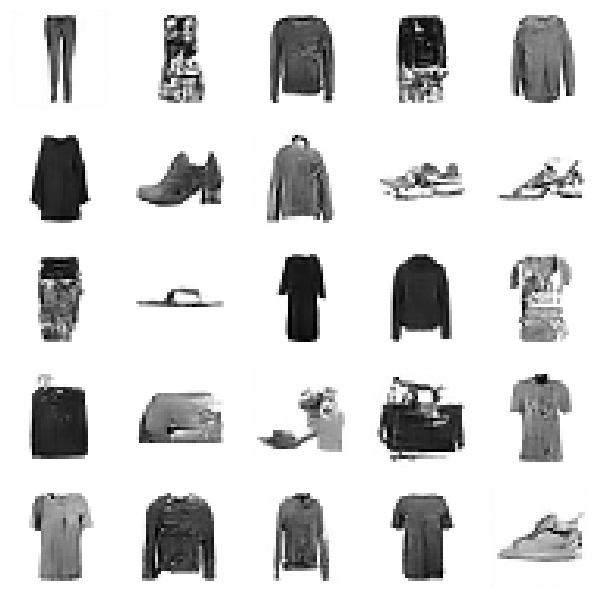

In [29]:
show_images(s[:25], imsize=1.5)

In [30]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [31]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [32]:
ie.fid(s), ie.kid(s)

(74.29736328125, 0.3116111755371094)

In [33]:
ie.fid(xb), ie.kid(xb)

(0.20068359375, 0.07478863000869751)

I'm using much smaller batch sizes in generating `s`, which could be the reason why for the much higher FID score (contrast with the much lower KID score).

KID is probably a better score in this context, given my small batch size.

## Diffusers DDIM Scheduler

In [34]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [35]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz, device=def_device)
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [36]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1] * 2).clamp(-1, 1)

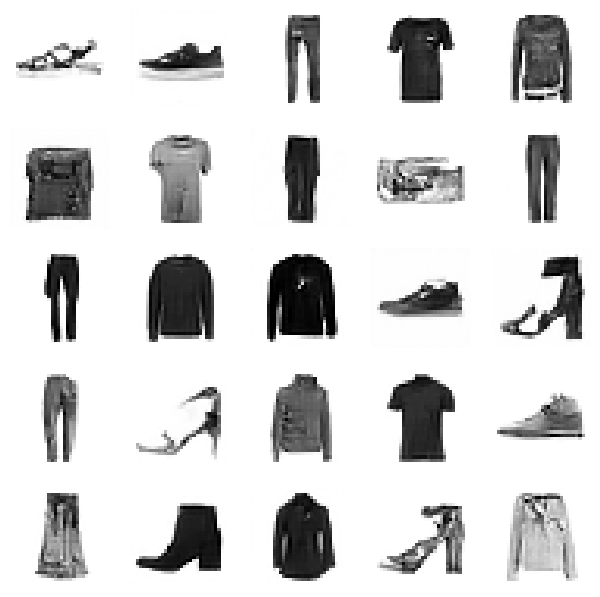

In [37]:
show_images(s[:25], imsize=1.5)

In [38]:
ie.kid(s)

0.0007544755935668945

## Implementing DDIM